# 7T presicion imaging paper

In [16]:
import pandas as pd
import numpy as np
import os
import glob
import nibabel as nb
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from brainstat.datasets.base import combine_surfaces
import matplotlib.cm as cm
import cmocean.cm as cmo

import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_10k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_10k != 0

# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

inf32_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.inflated.surf.gii', itype='gii')
inf32_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.inflated.surf.gii', itype='gii')

# Shape of the fsLR-5k matrices
N5k = 9684

In [8]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3')

# List of subjects
subs_pni = ['PNC0'+str(f"{x:02}") for x in list(range(1,11))]

# full path to 
dir_pni = 'BIDS_PNI/data_release'

# For PNI subjects
dirs_pni = []
for sub in subs_pni:
    dirs_pni.extend(glob.glob(f'{dir_pni}/derivatives/micapipe_v0.2.0/sub-{sub}/ses-*'))

# Sort the directories
dirs_pni = sorted(dirs_pni)

In [ ]:
def load_qmri_group(qmri='', subjects_list=None, maps='maps'):
    '''
    This function loads and plots the qMRI intensity maps on fsLR32k midthickness
    '''
    # List the files
    files_lh = []
    for path in subjects_list:
        files_lh.extend(glob.glob(f'{path}/{maps}/*_hemi-L_surf-fsLR-32k{qmri}.func.gii'))
    files_rh = []
    for path in subjects_list:
        files_rh.extend(glob.glob(f'{path}/{maps}/*_hemi-R_surf-fsLR-32k{qmri}.func.gii'))    
    
    files_lh = sorted(files_lh)
    files_rh = sorted(files_rh)

    # Load all the thickness data
    Nqmri=np.concatenate((nb.load(files_lh[0]).darrays[0].data, nb.load(files_rh[0]).darrays[0].data), axis=0).shape[0]

    surf_map=np.empty([len(files_lh), Nqmri], dtype=float)
    for i, _ in enumerate(files_lh):
        surf_map[i,:] = np.hstack(np.concatenate((nb.load(files_lh[i]).darrays[0].data, nb.load(files_rh[i]).darrays[0].data), axis=0))

    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)
    
    N = surf_map.shape[0]
    print(f"Numer of {qmri} maps: {N}")               
    return(map_mean,surf_map)

def plot_qmri_int(qmri='', midwall_mask=False, cmap='rocket', horiz=False, rq=(0.01, 0.99), 
                  subjects_list=None, crange=False, maps='maps'):
    
    # Load the data
    map_mean,_ = load_qmri_group(qmri, subjects_list=subjects_list, maps=maps)
    
    if crange == False:
        # Plot the group T1map intensitites
        crange=(np.quantile(map_mean[mask_32k], rq[0]), np.quantile(map_mean[mask_32k], rq[1]))

    # Replace values in f with NaN where mask_32k is False
    if midwall_mask == True: map_mean[mask_32k == False] = np.nan
    
    if horiz == True:
        fig = plot_hemispheres(inf32_lh, inf32_rh, array_name=map_mean, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, interactive=False, share='both',
                     nan_color=(0, 0, 0, 1), cmap=cmap, color_range=crange, transparent_bg=True, screenshot = False)

    else:
        fig = plot_hemispheres(inf32_lh, inf32_rh, array_name=map_mean, cmap=cmap, nan_color=(0, 0, 0, 1), transparent_bg=True,
                  zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', layout_style='grid', color_range=crange,
                  label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)
    return(fig)

import cmocean
cmaps = cmocean.cm.cmap_d

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_connectome(mtx, Title='matrix plot', xlab='X', ylab='Y', col='rocket', vmin=None, vmax=None,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0, size=(15,10)):
    
    '''
    This optional function, only plots a connectome as a heatmap
    Parameters
    ----------
    mtx : np.array
    Returns
    -------
    f : plot
    '''
    f, ax = plt.subplots(figsize=size)
    g = sns.heatmap(mtx, ax=ax, cmap=col, vmin=vmin, vmax=vmax, xticklabels=xticklabels, yticklabels=yticklabels)
    g.set_xlabel(xlab)
    g.set_ylabel(ylab)
    g.set_title(Title)
    # Rotate the x-axis labels
    # rotate tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=xrot, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=yrot, ha='right')
    
def load_fc(File):
    """Loads and process a functional connectome"""
    
    # load the matrix
    FC = nb.load(File).darrays[0].data
    
    # Fisher transform
    FCz = np.arctanh(FC)

    # replace inf with 0
    FCz[~np.isfinite(FCz)] = 0
    
    # Mirror the matrix
    FCz = np.triu(FCz,1)+FCz.T
    return FCz

# Figure 1. Methods
## F1. Time series (single subject)

In [12]:
# Path to time series
ts_file = f'{dirs_pni[0]}/func/desc-me_task-rest_bold/surf/sub-PNC001_ses-01_surf-fsLR-32k_desc-timeseries_clean.shape.gii'

# Load object
ts = nb.load(ts_file).darrays[0].data
ts.shape


(210, 64984)

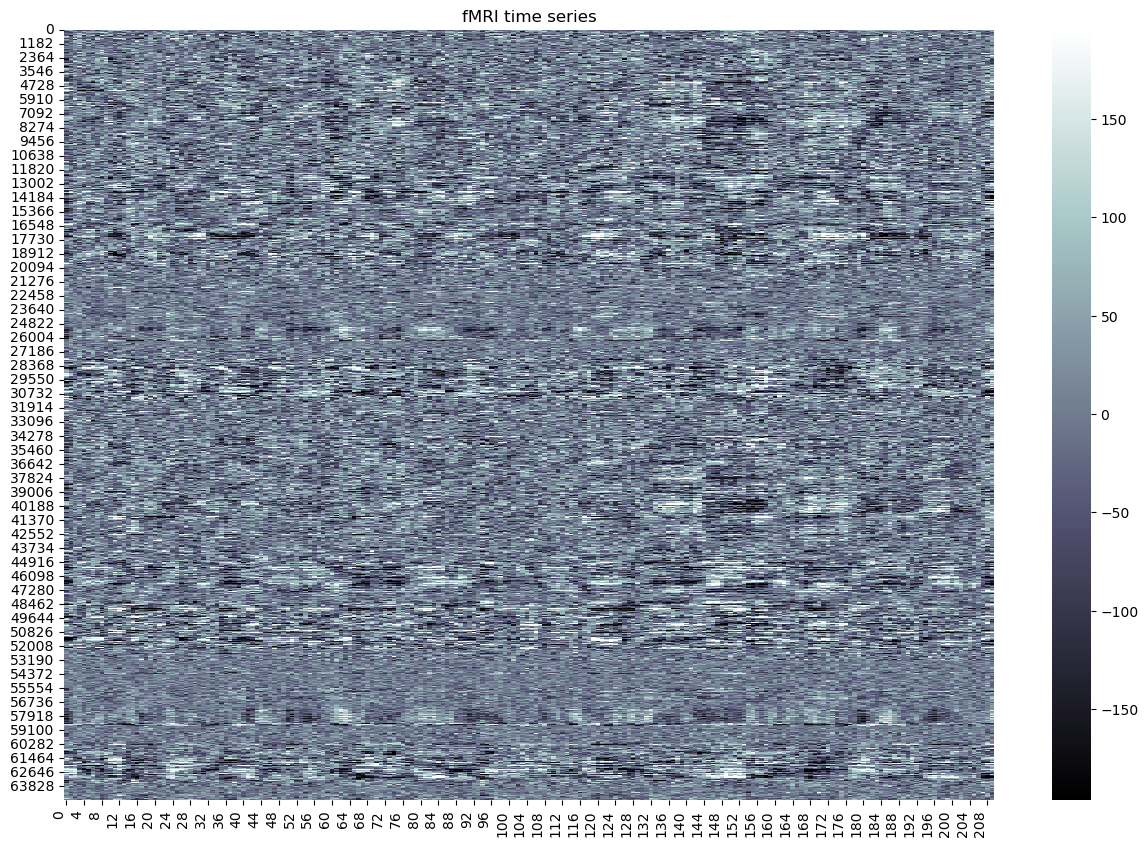

In [52]:
# plot the matrix connectome
plot_connectome(ts.T, Title='fMRI time series', xlab='', ylab='', col='bone', 
                vmin=np.quantile(ts, 0.01), vmax=np.quantile(ts, 0.99),
                xticklabels='auto', yticklabels='auto',xrot=90, yrot=0)


## F1. Functional Connectome

In [19]:
# List the files
fc_file = []
for path in dirs_pni:
    fc_file.extend(glob.glob(f'{path}/func/desc-me_task-rest_bold/surf/*_surf-fsLR-5k_desc-FC.shape.gii'))
N = len(fc_file)
print(f"Numer of FC: {N}") 

# Loads all the MPC fsLR-5k matrices
fc_5k=np.empty([N5k, N5k, len(fc_file)], dtype=float)
for i, f in enumerate(fc_file):
    fc_5k[:,:,i] = load_fc(f)

# Calculate the mean connectome
fc_5k_mean = np.mean(fc_5k, axis=2)


Numer of FC: 30


/host/yeatman/local_raid/temporaryLocalProcessing/ipykernel_16662/3893035645.py:32: RuntimeWarning: divide by zero encountered in arctanh
  FCz = np.arctanh(FC)


In [32]:
# Calculate the mean of each column
fc5k_colmean = np.mean(fc_5k_mean, axis=1)

# # Get the indices that would sort the array
# indx = np.argsort(fc5k_colmean)

# # Reorder the columns of the matrix
# fc5k_sorted = fc_5k_mean[:, indx]
# fc5k_sorted = fc5k_sorted[indx, :]

# fc5k_sorted.shape

(9684, 9684)

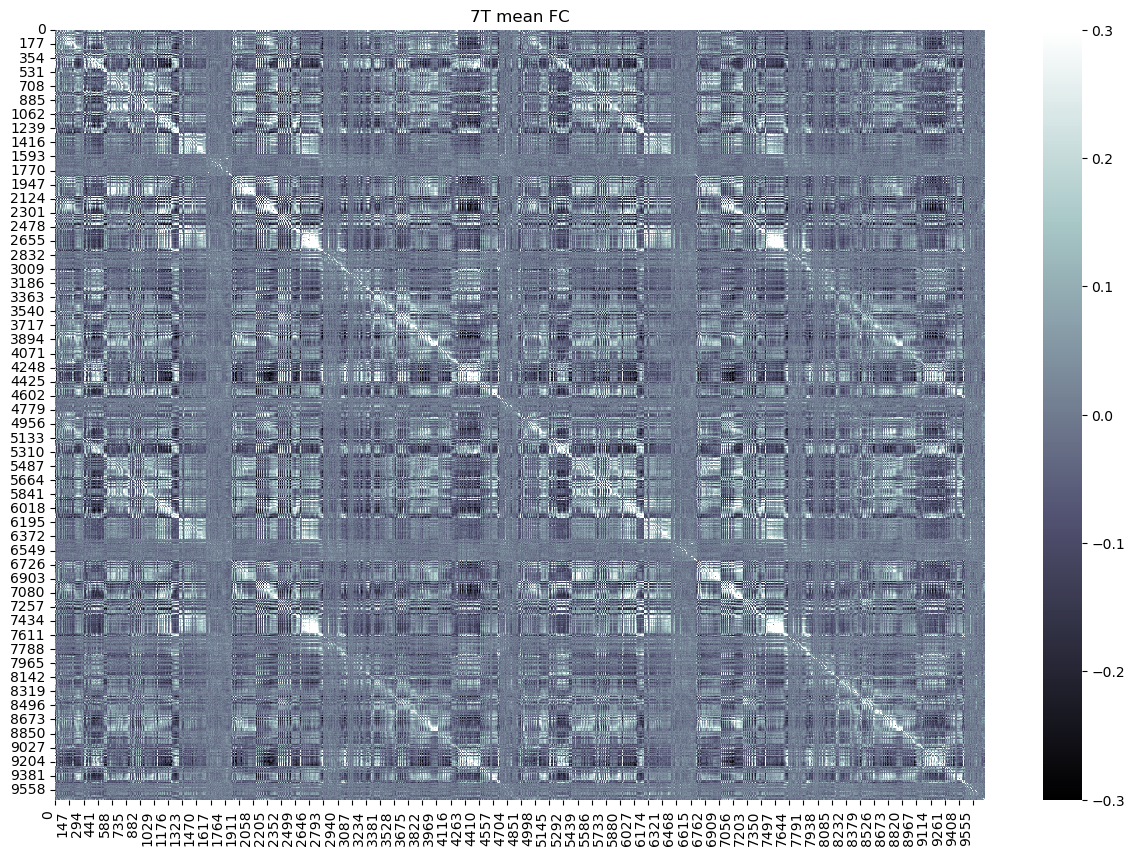

In [50]:
# plot the matrix connectome
plot_connectome(fc_5k_mean, Title='7T mean FC', xlab='', ylab='', col='bone', vmin=-0.3, vmax=0.3,
                   xticklabels='auto', yticklabels='auto',xrot=90, yrot=0)

## F1. Group mean FC

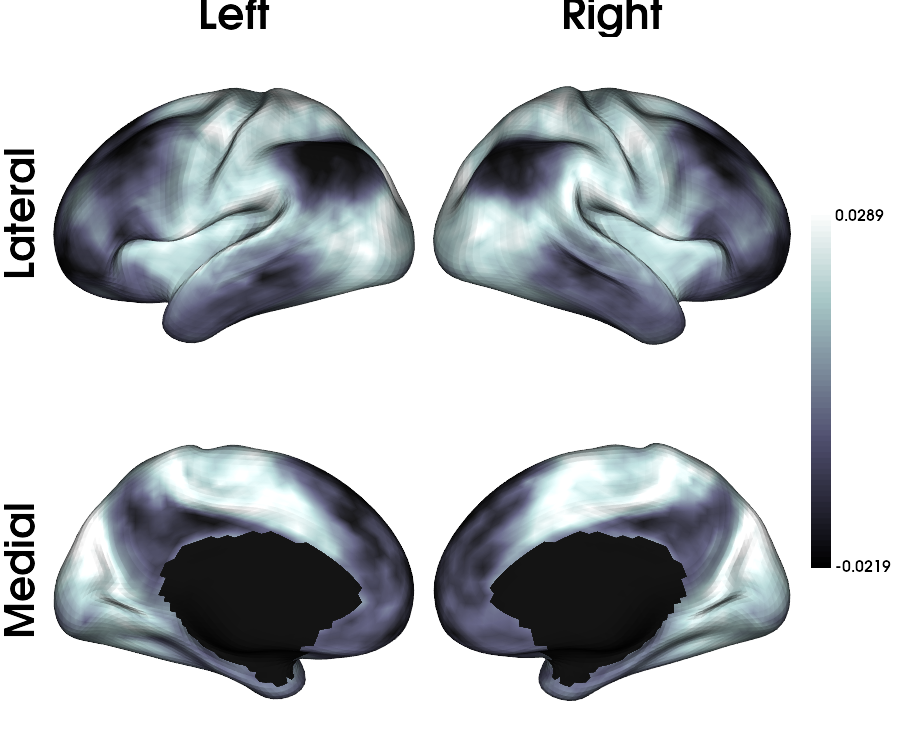

In [51]:
# plot the column mean of the mean connectome surface
crange=(np.quantile(fc5k_colmean[mask_surf], 0.01), np.quantile(fc5k_colmean[mask_surf], 0.99))
fc5k_colmean[mask_surf == False] = np.nan

plot_hemispheres(inf_lh, inf_rh, array_name=fc5k_colmean, cmap='bone', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', 
                 layout_style='grid', color_range=crange,
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)

## F1. tSNR

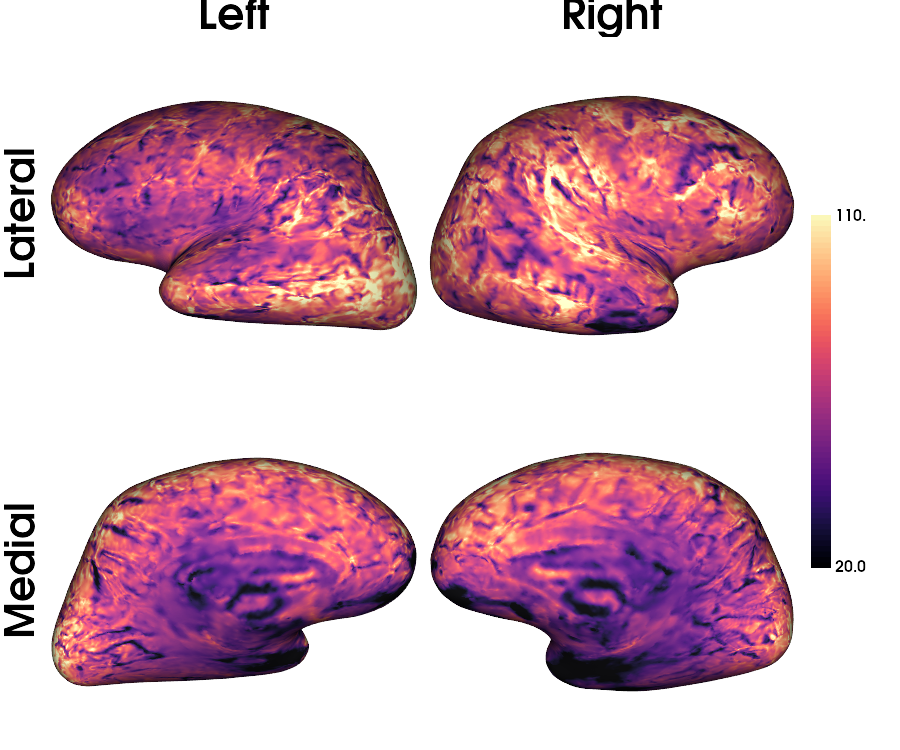

In [49]:
# Path to file
file_lh = f'{dirs_pni[0]}/func/desc-me_task-rest_bold/surf/sub-PNC001_ses-01_surf-fsnative_hemi-L_tSNR.shape.gii'
file_rh = f'{dirs_pni[0]}/func/desc-me_task-rest_bold/surf/sub-PNC001_ses-01_surf-fsnative_hemi-R_tSNR.shape.gii'

# Load
tSNR = np.hstack(np.concatenate((nb.load(file_lh).darrays[0].data, nb.load(file_rh).darrays[0].data), axis=0))

# Load inflated native surface
surf_dir = '/data_/mica3/BIDS_PNI/data_release/derivatives/fastsurfer/sub-PNC001_ses-01/surf'
nat_lh = read_surface(f'{surf_dir}/lh.inflated', itype='fs')
nat_rh = read_surface(f'{surf_dir}/rh.inflated', itype='fs')


# Color range
crange=(np.quantile(tSNR, 0.01), np.quantile(tSNR, 0.99))

# Plot on native surface
plot_hemispheres(nat_lh, nat_rh, array_name=tSNR, cmap='magma', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', 
                 layout_style='grid', color_range=(20,110),
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)


# Figure 2. Subject similarity connectome based
## F2. Group  mean FC Histogram 

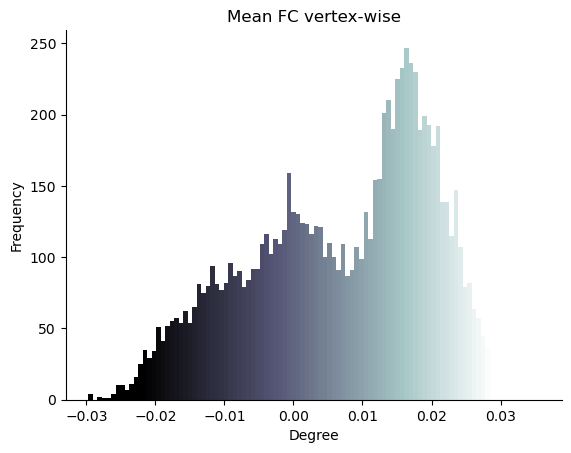

In [129]:
# Remove NaN from the variance
var_ft = fc5k_colmean[~np.isnan(fc5k_colmean)]
n, bins = np.histogram(var_ft, bins=100)  # Compute the histogram data
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colored_bins = cm.bone(np.interp(bin_centers, [np.quantile(fc5k_colmean[mask_surf], 0.01), 
                                               np.quantile(fc5k_colmean[mask_surf], 0.99)], [0, 1]))

# Create a figure with a transparent background
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

# Plot the histogram with the desired colormap
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=1)

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize ticks and labels
plt.xlabel('Degree', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
plt.title('Mean FC vertex-wise', fontsize=12)  # Increase font size for title

plt.show()


In [123]:
# Calculate the mean colum FC for all subjects
fc5k_sub = np.mean(fc_5k, axis=1)


In [177]:
# Number of subjects
N = fc5k_sub.shape[1] 

def get_id(str_dir):
    # Split the string by '/'
    parts = str_dir.split('/')

    # Extract the subject and session parts
    subject_part = parts[-2].split('-')[-1]  # 'PNC001'
    session_part = parts[-1].split('-')[-1]  # '01'

    # Concatenate them to get the desired result
    id_str = subject_part + 's' + session_part
    
    # result
    return(id_str)

def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

import cmocean
cmaps = cmocean.cm.cmap_d


## F2. Each subject FC on surface

In [71]:
# Iterate over each subject ses-01
for i in range(0, N, 3):
    
    # Subject ID
    sub_id = get_id(dirs_pni[i])
    png_name=f'/home/bic/rcruces/Desktop/7t_fmri/fc_{sub_id}.png'
    print(sub_id)

    # FC subject mean
    fc_sub = fc5k_sub[:, i]

    # Fix the range based on the mean FC
    crange=(np.quantile(fc_sub[mask_surf], 0.01), np.quantile(fc_sub[mask_surf], 0.99))

    # Mask the midwall
    fc_sub[mask_surf == False] = np.nan

    plot_hemispheres(inf_lh, inf_rh, array_name=fc_sub, cmap='bone', nan_color=(0, 0, 0, 1), 
                     transparent_bg=True, zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', 
                     layout_style='grid', color_range=crange,
                     label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, 
                     screenshot=True, filename=png_name)
    

PNC001s01
PNC002s01
PNC003s01
PNC004s01
PNC005s01
PNC006s01
PNC007s01
PNC008s01
PNC009s01
PNC010s01


## F2. Group variability

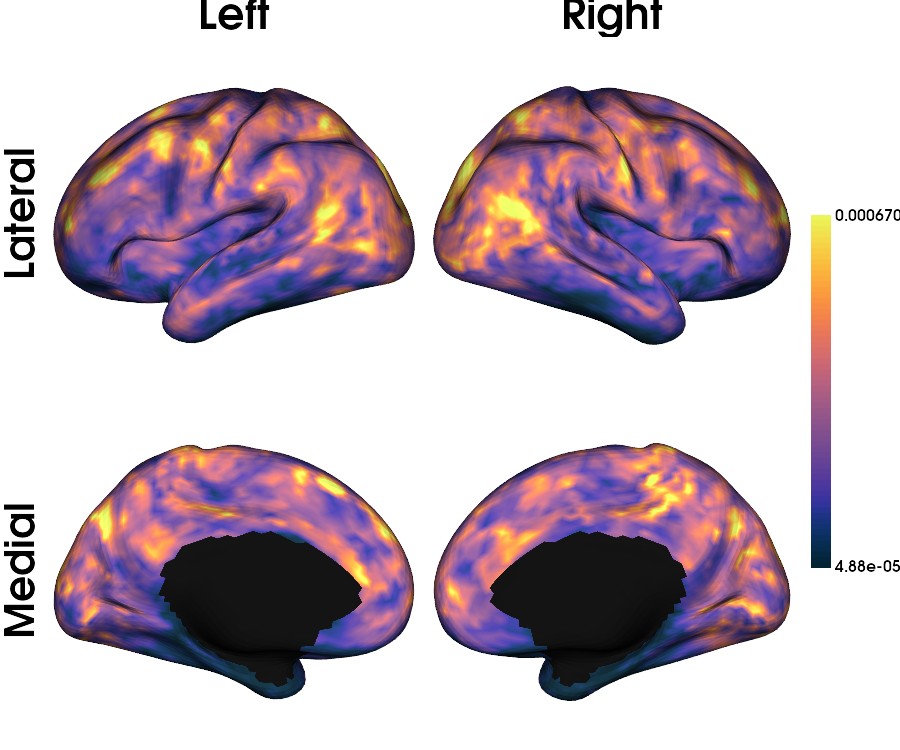

In [89]:
# Calculate the variance
map_var = np.var(fc5k_sub, axis=1)
#map_var = np.abs(map_mean/np.std(surf_map, axis=0))

# plot the column mean of the mean connectome surface
crange=(np.quantile(map_var[mask_surf], 0.01), np.quantile(map_var[mask_surf], 0.99))

# Plot it on the surface
plot_hemispheres(inf_lh, inf_rh, array_name=map_var, cmap='cmo.thermal', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', 
                 layout_style='grid', color_range=crange,
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)


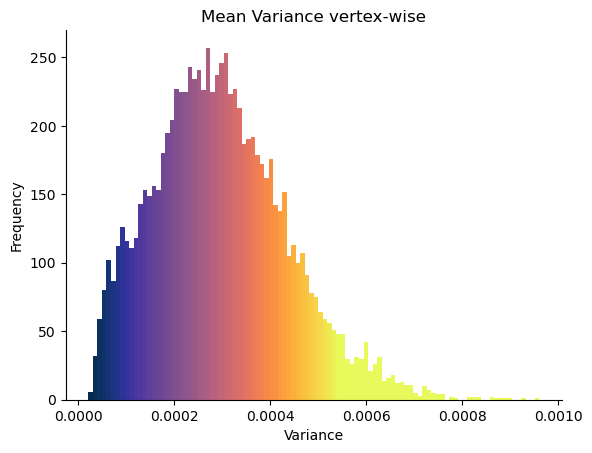

In [128]:
# Remove NaN from the variance
var_ft = map_var[~np.isnan(map_var)]
n, bins = np.histogram(var_ft, bins=100)  # Compute the histogram data
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colored_bins = cmo.thermal(np.interp(bin_centers, [0, np.nanquantile(map_var, 0.95)], [0, 1]))

# Create a figure with a transparent background
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

# Plot the histogram with the desired colormap
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=1)

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize ticks and labels
plt.xlabel('Variance', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
plt.title('Mean Variance vertex-wise', fontsize=12)  # Increase font size for title

plt.show()


## F2. Similarity matrix

In [126]:
corr = np.corrcoef(fc5k_sub[mask_surf,:].T)
bids_ids = [get_id(dir) for dir in dirs_pni]

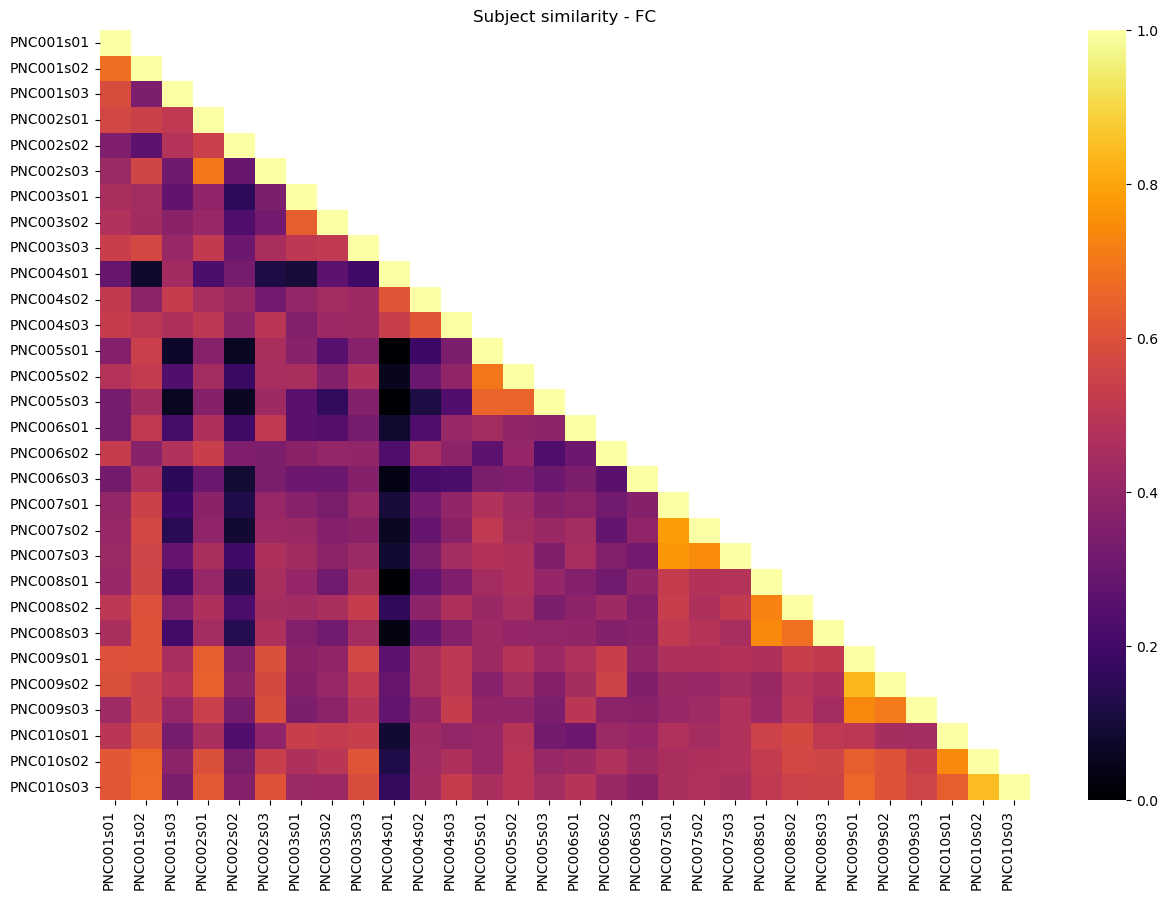

In [169]:
# Get the indices of the upper triangle, excluding the diagonal
upper_tri_indices = np.triu_indices_from(corr, k=1)

# Replace the upper triangle values with NaN
corr[upper_tri_indices] = np.nan

plot_connectome(corr, 'Subject similarity - FC', xlab=None, ylab=None, col='inferno', vmin=0, vmax=1,
                yticklabels=bids_ids, xticklabels=bids_ids)


## F2. Group mean to subject similarity

In [170]:
fc5k_sub_masked = fc5k_sub[mask_surf, :]  # Shape: (8856, 30)
fc5k_colmean_masked = fc5k_colmean[mask_surf]  # Shape: (8856,)

# Initialize an array to store the correlation coefficients
correlations = np.zeros((30, 1))

# Calculate the correlation for each column
for i in range(fc5k_sub_masked.shape[1]):
    col_data = fc5k_sub_masked[:, i]
    correlations[i] = np.corrcoef(col_data, fc5k_colmean_masked)[0, 1]

# Reshape the correlations array to be grouped in sets of three
correlations = correlations.reshape(30, 1)

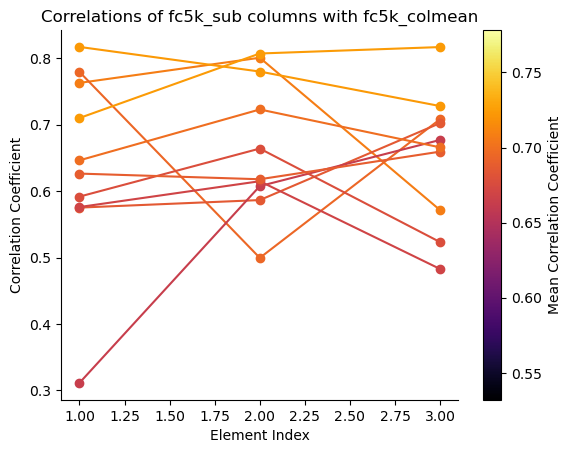

In [171]:
# Calculate the mean of each triplet
means = np.mean(correlations_reshaped, axis=1)

# Normalize the means to range between 0 and 1
norm = plt.Normalize(means.min(), means.max())

# Define colormap
cmap = cm.get_cmap('inferno')

# Plotting
fig, ax = plt.subplots(facecolor='none')

# Plot each triplet with corresponding color
for i, triplet in enumerate(correlations_reshaped):
    x_values = [1, 2, 3]  # x-axis values
    y_values = triplet.flatten()  # y-axis values
    mean_value = means[i]
    color = cmap(mean_value)  # Get color from colormap based on mean value
    ax.plot(x_values, y_values, marker='o', linestyle='-', color=color, label=f'Row {i+1}')

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set axes background color to be transparent
ax.patch.set_alpha(0)

# Setting labels and title
ax.set_xlabel('Element Index')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlations of fc5k_sub columns with fc5k_colmean')

# Add colorbar to represent the mean value
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Mean Correlation Coefficient')

# Save the figure with transparent background
plt.savefig('correlation_plot.png', transparent=True)

# Show plot
plt.show()

## F2. Between subjects similarity histogram

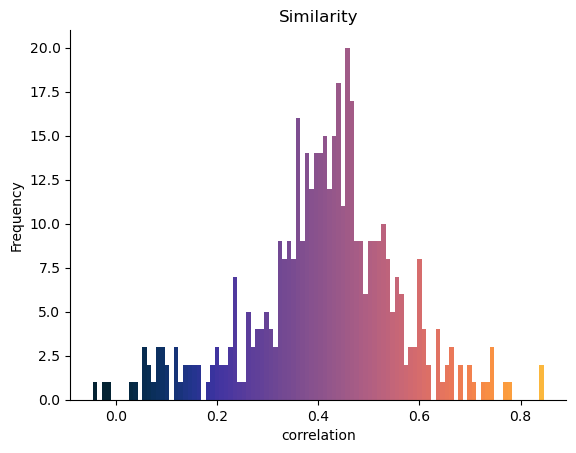

In [178]:
# Create the 1x2 layout for histograms
corr = np.corrcoef(fc5k_sub[mask_surf,:].T)
corr_sym = upper_tri_indexing(corr)

n, bins = np.histogram(corr_sym, bins=100)  # Compute the histogram data
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colored_bins = cmo.thermal(np.interp(bin_centers, [0, 1], [0, 1]))

# Create a figure with a transparent background
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

# Plot the histogram with the desired colormap
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=1)

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize ticks and labels
plt.xlabel('correlation', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
plt.title('Similarity', fontsize=12)  # Increase font size for title

plt.show()

# Figure 2. qT1

In [179]:
def load_mpc(File):
    """Loads and process a MPC"""

    # Load file
    mpc = nb.load(File).darrays[0].data
    
    # Mirror the lower triangle
    mpc = np.triu(mpc,1)+mpc.T
    
    # Replace infinite values with epsilon
    mpc[~np.isfinite(mpc)] = np.finfo(float).eps
    
    # Replace 0 with epsilon
    mpc[mpc==0] = np.finfo(float).eps
    
    # retun the MPC
    return(mpc)

In [180]:
# MPC T1map
qmri='T1map'
mpc_file = []
for path in dirs_pni:
    mpc_file.extend(glob.glob(f'{path}/mpc/acq-{qmri}/*surf-fsLR-5k_desc-MPC.shape.gii'))
N = len(mpc_file) 
print(f"Number of MPC: {N}") 

# Loads all the MPC fsLR-5k matrices
mpc_5k=np.empty([N5k, N5k, len(mpc_file)], dtype=float)
for i, f in enumerate(mpc_file):
    mpc_5k[:,:,i] = load_mpc(f)
    
# Mean group MPC colums
mpc_5k_mean = np.mean(mpc_5k, axis=2)

mpc_5k.shape

Numer of MPC: 30


['BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC001/ses-01/mpc/acq-T1map/sub-PNC001_ses-01_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC001/ses-02/mpc/acq-T1map/sub-PNC001_ses-02_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC001/ses-03/mpc/acq-T1map/sub-PNC001_ses-03_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC002/ses-01/mpc/acq-T1map/sub-PNC002_ses-01_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC002/ses-02/mpc/acq-T1map/sub-PNC002_ses-02_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC002/ses-03/mpc/acq-T1map/sub-PNC002_ses-03_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.2.0/sub-PNC003/ses-01/mpc/acq-T1map/sub-PNC003_ses-01_surf-fsLR-5k_desc-MPC.shape.gii',
 'BIDS_PNI/data_release/derivatives/micapipe_v0.

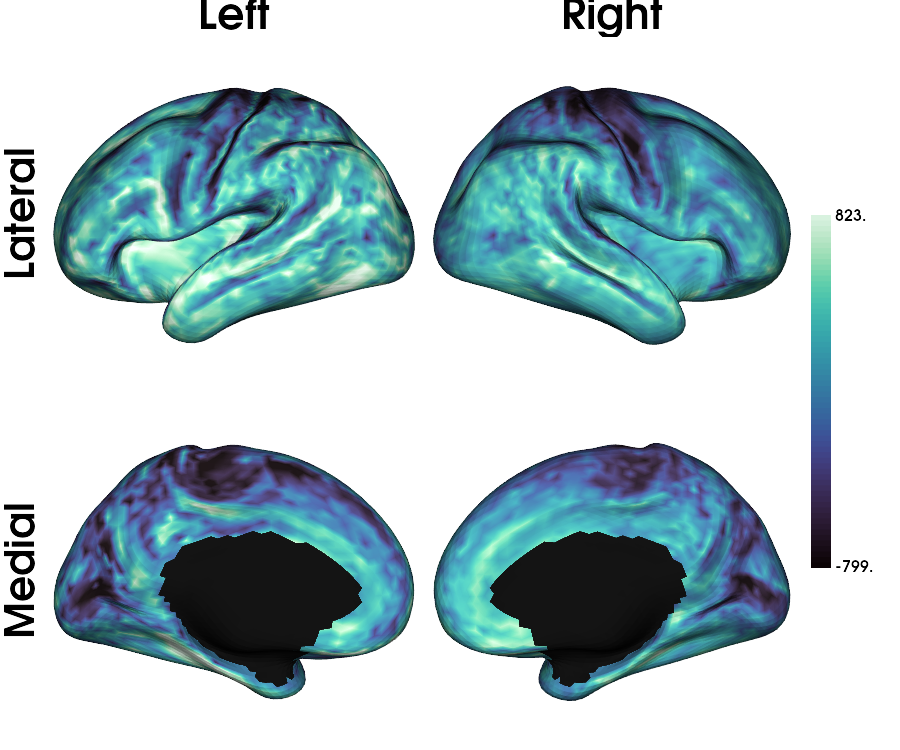

In [194]:
# Calculate the column mean
map_mean=np.sum(mpc_5k_mean, axis=1)

# plot the column mean of the mean connectome surface
crange=(np.quantile(map_mean[mask_surf], 0.01), np.quantile(map_mean[mask_surf], 0.99))
map_mean[mask_surf == False] = np.nan

plot_hemispheres(inf_lh, inf_rh, array_name=map_mean, cmap='mako', nan_color=(0, 0, 0, 1), 
                 transparent_bg=True, zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', 
                 layout_style='grid', color_range=crange,
                 label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, screenshot=False)

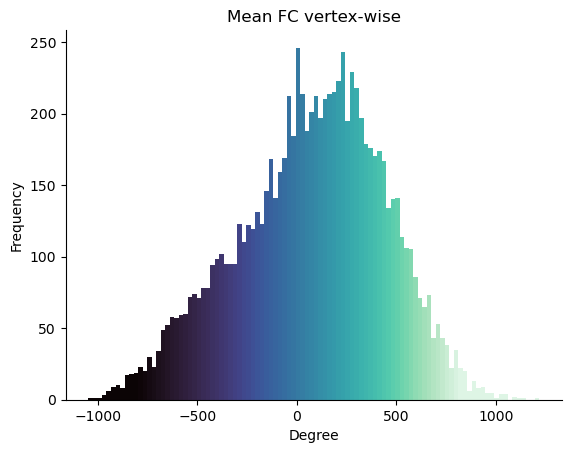

In [185]:
# Remove NaN from the variance
var_ft = map_mean[~np.isnan(map_mean)]
n, bins = np.histogram(var_ft, bins=100)  # Compute the histogram data
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers

# Use Seaborn's 'mako' colormap
cmap = sns.color_palette("mako", as_cmap=True)
colored_bins = cmap(np.interp(bin_centers, [np.quantile(map_mean[mask_surf], 0.01), 
                                            np.quantile(map_mean[mask_surf], 0.99)], [0, 1]))

# Create a figure with a transparent background
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

# Plot the histogram with the desired colormap
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=1)

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize ticks and labels
plt.xlabel('Degree', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
plt.title('Mean FC vertex-wise', fontsize=12)  # Increase font size for title

plt.show()

In [196]:
# Calculate the degree colum FC for all subjects
fc5k_sub = np.sum(mpc_5k, axis=1)

# Iterate over each subject ses-01
for i in range(0, N, 3):
    # Subject ID
    sub_id = get_id(dirs_pni[i])
    png_name=f'/home/bic/rcruces/Desktop/7t_fmri/qt1_{sub_id}.png'
    print(sub_id)

    # subject mean
    fc_sub = fc5k_sub[:, i]

    # Fix the range based on the mean FC
    crange=(np.quantile(fc_sub[mask_surf], 0.01), np.quantile(fc_sub[mask_surf], 0.99))

    # Mask the midwall
    fc_sub[mask_surf == False] = np.nan

    plot_hemispheres(inf_lh, inf_rh, array_name=fc_sub, cmap='mako', nan_color=(0, 0, 0, 1), 
                     transparent_bg=True, zoom=1.3, size=(900, 750), embed_nb=True, color_bar='right', 
                     layout_style='grid', color_range=crange,
                     label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']}, 
                     screenshot=True, filename=png_name)
    

PNC001s01
PNC002s01
PNC003s01
PNC004s01
PNC005s01
PNC006s01
PNC007s01
PNC008s01
PNC009s01
PNC010s01


In [187]:
## F2. qT1 similarity

(9684, 9684, 30)

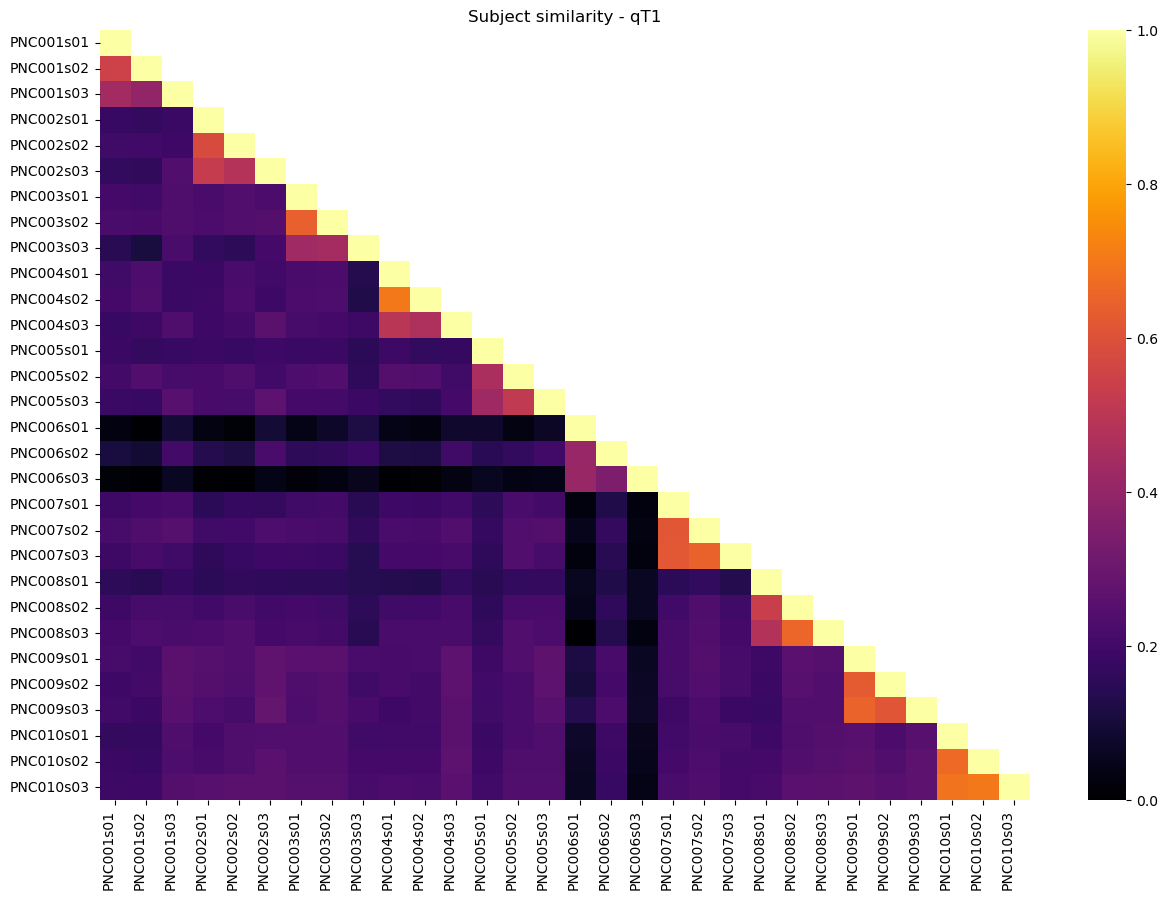

In [198]:
corr = np.corrcoef(fc5k_sub[mask_surf,:].T)
bids_ids = [get_id(dir) for dir in dirs_pni]

# Get the indices of the upper triangle, excluding the diagonal
upper_tri_indices = np.triu_indices_from(corr, k=1)

# Replace the upper triangle values with NaN
corr[upper_tri_indices] = np.nan

plot_connectome(corr, 'Subject similarity - qT1', xlab=None, ylab=None, col='inferno', vmin=0, vmax=1,
                yticklabels=bids_ids, xticklabels=bids_ids)



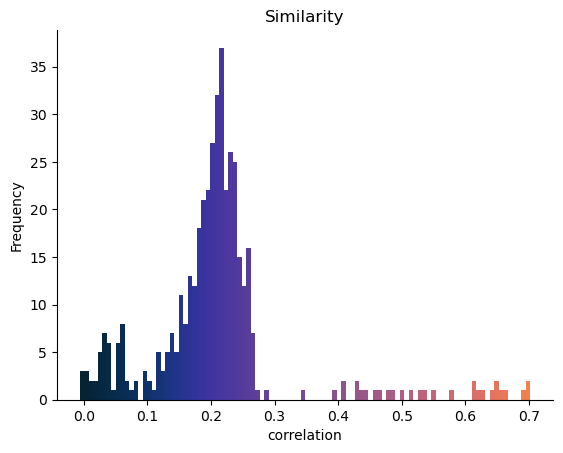

In [199]:
# Create the 1x2 layout for histograms
corr = np.corrcoef(fc5k_sub[mask_surf,:].T)
corr_sym = upper_tri_indexing(corr)

n, bins = np.histogram(corr_sym, bins=100)  # Compute the histogram data
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
colored_bins = cmo.thermal(np.interp(bin_centers, [0, 1], [0, 1]))

# Create a figure with a transparent background
fig, ax = plt.subplots()
fig.patch.set_alpha(0.0)  # Set the background of the figure to be transparent
ax.patch.set_alpha(0.0)  # Set the background of the axes to be transparent

# Plot the histogram with the desired colormap
plt.bar(bin_centers, n, width=np.diff(bins), color=colored_bins, alpha=1)

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize ticks and labels
plt.xlabel('correlation', fontsize=10)  # Increase font size for x-label
plt.ylabel('Frequency', fontsize=10)  # Increase font size for y-label
plt.title('Similarity', fontsize=12)  # Increase font size for title

plt.show()

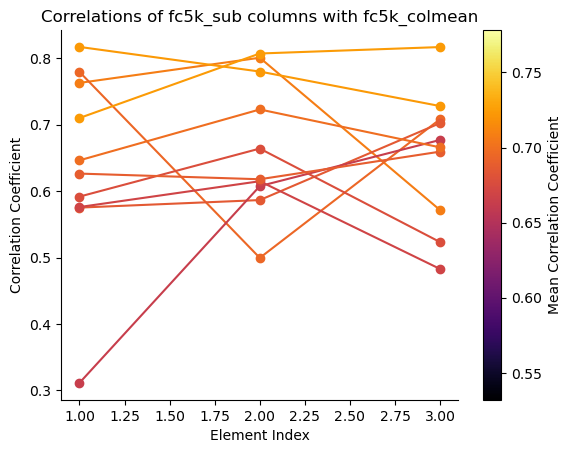

In [203]:
# Calculate the mean of each column
fc5k_colmean = np.mean(mpc_5k_mean, axis=1)

fc5k_sub_masked = fc5k_sub[mask_surf, :]  # Shape: (8856, 30)
fc5k_colmean_masked = fc5k_colmean[mask_surf]  # Shape: (8856,)

# Initialize an array to store the correlation coefficients
correlations = np.zeros((30, 1))

# Calculate the correlation for each column
for i in range(fc5k_sub_masked.shape[1]):
    col_data = fc5k_sub_masked[:, i]
    correlations[i] = np.corrcoef(col_data, fc5k_colmean_masked)[0, 1]

# Reshape the correlations array to be grouped in sets of three
correlations = correlations.reshape(30, 1)

# Calculate the mean of each triplet
means = np.mean(correlations_reshaped, axis=1)

# Normalize the means to range between 0 and 1
norm = plt.Normalize(means.min(), means.max())

# Define colormap
cmap = cm.get_cmap('inferno')

# Plotting
fig, ax = plt.subplots(facecolor='none')

# Plot each triplet with corresponding color
for i, triplet in enumerate(correlations_reshaped):
    x_values = [1, 2, 3]  # x-axis values
    y_values = triplet.flatten()  # y-axis values
    mean_value = means[i]
    color = cmap(mean_value)  # Get color from colormap based on mean value
    ax.plot(x_values, y_values, marker='o', linestyle='-', color=color, label=f'Row {i+1}')

# Remove upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set axes background color to be transparent
ax.patch.set_alpha(0)

# Setting labels and title
ax.set_xlabel('Element Index')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Correlations of fc5k_sub columns with fc5k_colmean')

# Add colorbar to represent the mean value
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Mean Correlation Coefficient')

# Save the figure with transparent background
plt.savefig('correlation_plot.png', transparent=True)

# Show plot
plt.show()

# Figure 3. Subject specific differences across networks subject based networks

# Figure 4. Single vs Multi-session quality assesment

# Figure 5. Spatial shifts in a multidimentional space